In [1]:
import numpy as np
import pandas as pd
import ssl
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import random
import pickle
from pprint import pprint

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN, SMOTENC, SVMSMOTE
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import hamming_loss, roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import wordcloud

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer



import scikitplot as skplt
import matplotlib.pyplot as plt

from keras import optimizers
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from scipy.special import softmax

ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [2]:
def clean_statement(statement):
#     x = re.sub('-', ' ', x)
    statement = re.sub('$', ' ', statement)
    statement = re.sub('[^A-Za-z]+', ' ', statement)
    statement = re.sub('[,|.|?|\n]|\t', '', statement)
    statement = re.sub('n\'t', ' ', statement)
    statement = re.sub('submission|submissions|Submission|submission|th ', '', statement)
    statement = re.sub('one|two|given|need', '', statement)
    
    return statement

In [3]:
def process_problem_statement(q_statement):
    
    q_statement = clean_statement(q_statement)
    
#     q_statement = re.sub('[^A-Za-z]+', ' ', q_statement)
    
    tokens = word_tokenize(q_statement)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in q_statement.lower().split() if i not in stoplist]
    
    ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    q_statement = ' '.join(word_list)
    
#     print(q_statement)
    
    return q_statement

In [4]:
def process_problem_solution(solution):
    
#     solution = clean_statement(solution)
    
    tokens = word_tokenize(solution)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in solution.lower().split() if i not in stoplist]
    
#     ps = PorterStemmer()
    
#     word_list = [ps.stem(word) for word in word_list]
    
    solution = ' '.join(word_list)
    
#     print(q_statement)
    
    return solution

In [5]:
def process_time_taken(time_col):
#     print(time_col.split())
    return time_col.split()[0]

In [6]:
def process_tags(all_tags_list,tag_col):
    
#     print(tag_col)
    tags_present = list(re.split(',',tag_col))
    return tags_present

In [7]:
def get_all_distinct_tags(tags_col):
    
    tags_list = []
    
    t_sets = set(tags_list)
    
    for row in tags_col:
#         print(row)
        t_list = re.split(',',row)
#         print(t_list)
        t_sets = t_sets.union(set(t_list))
#         print(t_sets)
    tags_list = list(t_sets)
    
    stoplist = set(stopwords.words('english'))
    
    word_list = [i for i in tags_list if i not in stoplist]
    
    return tags_list

In [8]:
# tag list obtained from the dataset
# global tags_list

tags_list = ['dsu', 'trees', 'chinese remainder theorem', 'sortings', 'games', 'implementation', 'bitmasks',
              '*special', 'hashing', 'geometry', 'two pointers', 'combinatorics', 'flows', 'strings',
              'probabilities', 'data structures', 'ternary search', 'greedy', 'math', 'matrices',
              'divide and conquer', 'dfs and similar', 'constructive algorithms', 'brute force', 'dp',
              '2-sat', 'graph matchings', 'binary search', 'number theory', 'graphs', 'fft', 'shortest paths',
              'schedules', 'meet-in-the-middle', 'string suffix structures', 'expression parsing']



In [9]:
def plot_class_distribution(Y,classes):
    
    count_list = [0]*Y.shape[1]
    
    for index in range(Y.shape[1]):
        
        count_list[index] = np.sum(Y[:,index])/Y.shape[0]
    
    plt.figure(figsize=(8, 8), dpi=100)
    
    plt.barh(classes,count_list, align='center', alpha=0.5)
#     plt.bar(np.arange(Y.shape[1]),count_list, align='center', alpha=0.5)
#     plt.plot(np.arange(Y.shape[1]),count_list)
    plt.show()
    

In [10]:
def data_preprocessing():
    
    global X, Y, mlb, distinct_tags
    
    df = pd.read_csv("codeforces_question_v5.csv")
    df = df.drop(['id','name','author'],axis = 1)
    df = df[df.solution != "no code found"]
    df = df.dropna()
    
    distinct_tags = get_all_distinct_tags(df["tags"])
    
    df["problem statement"] = [process_problem_statement(x) for x in df["problem statement"]]
    df["solution"] = [process_problem_solution(x) for x in df["solution"]]
    df["time_taken"] = [process_time_taken(x) for x in df["time_taken"]]
    
#     X = copy.deepcopy(df["solution"]+df["time_taken"])
#     X = copy.deepcopy(df["solution"])
    X = copy.deepcopy(df["problem statement"])
    Y = [process_tags(distinct_tags,x) for x in df["tags"]]

    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(Y)
    
    
    
    plot_class_distribution(Y,mlb.classes_)

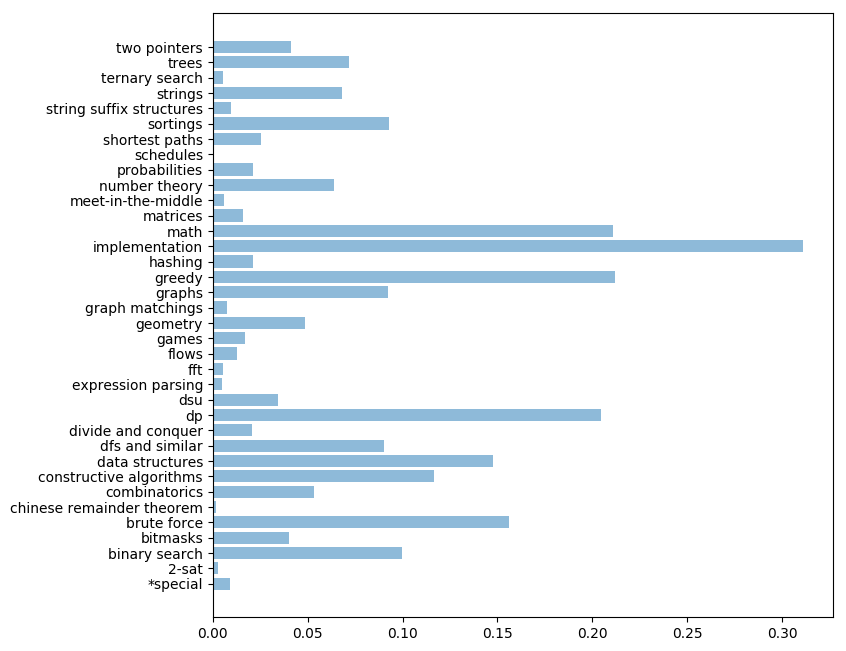

In [11]:
data_preprocessing()

In [13]:
def reduce_sample_imbalance(X_train,Y_train):
    
    global X, Y, mlb, distinct_tags
    
    X_train = pd.DataFrame(X_train).values
    
    xtrain_col_index = X_train.shape[1]
    xtrain_row_index = X_train.shape[0]
    
    XY = np.column_stack((X_train,Y_train))
    
    labels = [0]*len(mlb.classes_)
    row_index_to_delete = []
    ratio = []
    
    for index in range(Y_train.shape[1]):
        ratio.append(np.sum(Y_train[:,index])/Y_train.shape[0])
        if np.sum(Y_train[:,index])/Y_train.shape[0] > 0.03:
            
            labels[index] = 1
            
    ratio.sort()

    count_deletions = [0]*len(labels)
    for index in range(len(labels)):
        if labels[index] == 1:

            count_deletions[index] = int(np.sum(Y_train[:,index]) * 0.97)    
    
    for index in range(Y_train.shape[0]):
        flag_to_delete = True
        
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if Y_train[index][yindex-X_train.shape[1]] == 1:
                if labels[yindex-X_train.shape[1]] == 0 or count_deletions[yindex-X_train.shape[1]] <= 0:
                    flag_to_delete = False
                    break
        
        if flag_to_delete:
            row_index_to_delete.append(index)
            for i in range(len(count_deletions)):
                count_deletions[i] -= Y_train[index][i]
    
        if sum(count_deletions) <= 0:
            break;
            
    XY = np.delete(XY, row_index_to_delete,axis=0)
    
    ratio = []
    for index in range(X_train.shape[1],XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
    
    plot_class_distribution(XY[:,X_train.shape[1]:],mlb.classes_)
    
    
    data_to_repeat_index = [1]*XY.shape[0]
    labels = [0]*len(mlb.classes_)
    ratio = []
    for index in range(xtrain_col_index,XY.shape[1]):
        ratio.append(np.sum(XY[:,index])/XY.shape[0])
        if np.sum(XY[:,index])/XY.shape[0] < 0.02:
            labels[index-xtrain_col_index] = 1
    

    ratio.sort()
        
    for index in range(XY.shape[0]):
        for yindex in range(X_train.shape[1],XY.shape[1]):
            if XY[index][yindex] == 1 and labels[yindex-X_train.shape[1]] > 0:
                data_to_repeat_index[index] = 100
                labels[yindex-X_train.shape[1]] = -1
    
    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0)

    X_train = XY[:,0]
    Y_train = XY[:,1:]
            
    X_train = pd.Series(X_train)
    X_train = X_train.astype(str)
    Y_train = Y_train.astype('int') 
    return X_train,Y_train

In [15]:
def oversample_train_data(X_train,Y_train):
    
    global X, Y, mlb, distinct_tags
    
    X_train = pd.DataFrame(X_train).values
    
    XY = np.column_stack((X_train,Y_train))
    
    labels = []
    data_to_repeat_index = [1]*Y_train.shape[0]
    
    for index in range(Y_train.shape[1]):
        if np.sum(Y_train[:,index])/Y_train.shape[0] < 0.02:
            labels.append(index)
    
    for index in range(Y_train.shape[0]):
        for label in labels:
            if Y_train[index][label] == 1:
                data_to_repeat_index[index] = 200
    

    XY = np.repeat(XY, repeats = data_to_repeat_index, axis=0)
    
    X_train = XY[:,0]
    Y_train = XY[:,1:]
        
#     Ytrain = mlb.inverse_transform(Y_train)
    
#     print(Ytrain)
    
    X_train = pd.Series(X_train)
    X_train = X_train.astype(str)
    Y_train = Y_train.astype('int') 
    return X_train,Y_train